# Preparation

In [1]:
from pathlib import Path
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import argparse
import sys
import torch
import warnings


data_folder = Path("/blue/li.chen1/yi.xia/Projects/MPRA/Additional_data/Data10")

input_dir = '/blue/li.chen1/yi.xia/Projects/MPRA/Additional_data/Data10'
output_dir = '/blue/li.chen1/yi.xia/Projects/MPRA/Additional_data/Data10'
fasta_output_dir = '/blue/li.chen1/yi.xia/Projects/MPRA/Additional_data/Data10'

In [2]:
%run /blue/li.chen1/yi.xia/Projects/MPRA/libMPRA.ipynb
%run /blue/li.chen1/yi.xia/Projects/MPRA/modelMPRA.ipynb
%run /blue/li.chen1/yi.xia/Projects/MPRA/trainMPRA.ipynb

%run /blue/li.chen1/yi.xia/Projects/MPRA/GANS/libcVAE.ipynb
%run /blue/li.chen1/yi.xia/Projects/MPRA/GANS/modelcVAE.ipynb


torch.cuda.is_available()
torch.cuda.device_count()

warnings.filterwarnings("ignore")

/blue/li.chen1/yi.xia/conda/envs/hfrl/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/blue/li.chen1/yi.xia/conda/envs/hfrl/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
idata='data10'
celltypes = ["Jurkat"]

fractions = [0.2, 0.5, 1.0]
fractions_json = ['0.2', '0.5', '1.0']

In [4]:
BATCH_SIZE = 64
INIT_LR = 1e-4
early_stop_thresh = 10
EPOCHS=50
random_state=1234
seed=1234

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
latent_dim = 64
model = cVAE(latent_dim).to(device)

In [7]:
lr = 2e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [8]:
for celltype in celltypes:
    print(celltype)
    x_pos_seq, x_neg_seq, x_pos_seq_rev, x_neg_seq_rev, x_pos_seq_crop, x_neg_seq_crop, x_unlabeled_seq = readData(idata, celltype)

Jurkat
true, pos and neg:  [(195, 1001, 4), (1950, 1001, 4)]
rev, pos and neg:  [(585, 1001, 4), (5850, 1001, 4)]
crop, pos and neg:  [(390, 1001, 4), (3900, 1001, 4)]
unlabeled:  [(16156, 1001, 4)]


# testdata_indices

In [10]:
%%capture
def process_fractions_allmethods(celltype, fractions, combinations, x_pos_seq, x_neg_seq, x_pos_seq_rev, x_neg_seq_rev, x_pos_seq_crop, x_neg_seq_crop, x_unlabeled_seq,
                                 dropout_rate, num_kernels, BATCH_SIZE,INIT_LR, early_stop_thresh, EPOCHS, NUM_ITERATIONS, results, input_dir, output_dir, 
                                 data_folder, device, random_state):
    
    testData_indices_df = pd.DataFrame()

    for iteration in range(NUM_ITERATIONS):
        start_time = time.time()
        
        current_seed = random_state + iteration
        np.random.seed(int(current_seed))
        
        x_pos_seq_trainval, x_neg_seq_trainval, x_pos_seq_rev_trainval, x_neg_seq_rev_trainval, x_pos_seq_crop_trainval, x_neg_seq_crop_trainval, testData, testData_indices, x_test_noswap, y_test=split_testdata(
            x_pos_seq, x_neg_seq, x_pos_seq_rev, x_neg_seq_rev, x_pos_seq_crop, x_neg_seq_crop, test_size=0.2, seed=current_seed, verbose=1)
        
        iteration_df = pd.DataFrame(testData_indices.reshape(-1, 1), columns=[f'Iteration_{iteration + 1}'])
        testData_indices_df = pd.concat([testData_indices_df, iteration_df], axis=1)
        
    testData_indices_df.to_csv(f'{output_dir}/{celltype}_testData_indices.csv', index=False)
    
    
combinations = ['true', 'true+rev', 'true+crop', 'true+rev+crop', 'VAE', 'Semi', 'Semi+truecroprev_v1', 'Semi+truecroprev_v2','Random_forest'] 

#celltypes = ["Jurkat"]
celltypes = ["autoimmune_disease"]

results = {cell: {fraction: {combine: {'Accuracy': [],'AUC': [],'AUPRC': [],'f1': [],'precision': [],'recall': [],'R': [],'predsProb': [],'preds': [],'y_test': []} for combine in combinations} for fraction in fractions} for cell in celltypes}

NUM_ITERATIONS = 50

for celltype in celltypes:
    print('####################################')
    print('########### Celltype:', celltype, '##########')
    print('####################################')
    # Retrieve dropout_rate and num_kernels for the current celltype
    
    #dropout_rate = dropout_rates_dict[celltype]
    #num_kernels = num_kernels_dict[celltype]
    
    dropout_rate = 0.1
    num_kernels = (128, 256)
    
    x_pos_seq, x_neg_seq, x_pos_seq_rev, x_neg_seq_rev, x_pos_seq_crop, x_neg_seq_crop, x_unlabeled_seq = readData(idata, celltype)
    
#    x_pos_seq_trainval, x_neg_seq_trainval, x_pos_seq_rev_trainval, x_neg_seq_rev_trainval, x_pos_seq_crop_trainval, x_neg_seq_crop_trainval, testData=split_testdata(
#        x_pos_seq, x_neg_seq, x_pos_seq_rev, x_neg_seq_rev, x_pos_seq_crop, x_neg_seq_crop, test_size=0.2, seed=1234, verbose=1)
    
    process_fractions_allmethods(celltype, fractions, combinations, x_pos_seq, x_neg_seq, x_pos_seq_rev, x_neg_seq_rev, x_pos_seq_crop, x_neg_seq_crop, x_unlabeled_seq,
                                           dropout_rate, num_kernels, BATCH_SIZE, INIT_LR, early_stop_thresh, EPOCHS, NUM_ITERATIONS, results, input_dir, output_dir, 
                                           data_folder, device, random_state)

# Random Forest to get base AUC

In [9]:
# Random Forest to get baseline AUC
for downsample in fractions:
    RF_baseline_auc_with_5foldCV(celltypes, idata, downsample=downsample)

########### downsample: 0.1 ###########
#### celltype: Jurkat ####
Mean AUC Score(5-fold CV): 0.4949
########### downsample: 0.5 ###########
#### celltype: Jurkat ####
Mean AUC Score(5-fold CV): 0.6791
########### downsample: 1.0 ###########
#### celltype: Jurkat ####
Mean AUC Score(5-fold CV): 0.6835


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from collections import Counter
import itertools

def onehot(fafile):
    x = []
    for seq_record in SeqIO.parse(fafile, "fasta"):
        #print(seq_record.id)
        #print(seq_record.seq)
        #get sequence into an array
        seq_array = np.array(list(seq_record.seq))

        # Check if sequence length is as expected (1001)
        if len(seq_array) != 1001:
            print(f"Warning: Sequence length {len(seq_array)} is not 1001")
            # Handle the case where sequence length is not 1001, e.g., by skipping or padding
            continue

        # Integer encode the sequence
        label_encoder = LabelEncoder()
        integer_encoded_seq = label_encoder.fit_transform(seq_array)

        # One-hot encode the sequence
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded_seq = integer_encoded_seq.reshape(len(integer_encoded_seq), 1)
        onehot_encoded_seq = onehot_encoder.fit_transform(integer_encoded_seq)

        # Ensure the one-hot encoded sequence has the shape (1001, 4)
        if onehot_encoded_seq.shape != (1001, 4):
            print(f"Unexpected shape: {onehot_encoded_seq.shape}")
            continue
        x.append(onehot_encoded_seq)
    x = array(x)
    return x

def readData_nounlabeled(idata,celltype):
    # true data
    seq_pos_file='seq.'+idata+'.'+celltype+'.pos.fasta'
    x_pos_seq=onehot(data_folder/seq_pos_file)
    seq_neg_file='seq.'+idata+'.'+celltype+'.neg.fasta'
    x_neg_seq=onehot(data_folder/seq_neg_file)

    print('true, pos and neg: ',[x_pos_seq.shape,x_neg_seq.shape])
    
    return x_pos_seq,x_neg_seq

def genData_downsample(x_pos_seq, x_neg_seq, seed=1234, fraction=1.0, combine='true', verbose=0):
    
    np.random.seed(1234)
    
    # True data
    y_pos = np.ones(x_pos_seq.shape[0])
    y_neg = np.zeros(x_neg_seq.shape[0])
    original_len_pos = x_pos_seq.shape[0]
    original_len_neg = x_neg_seq.shape[0]
    x_pos_seq_downsample, y_pos_downsample, pos_indices = downsample_data(x_pos_seq, y_pos, fraction)
    x_neg_seq_downsample, y_neg_downsample, neg_indices = downsample_data(x_neg_seq, y_neg, fraction)
    

    y = np.concatenate((y_pos_downsample, y_neg_downsample), axis=0)
    x_seq = np.concatenate((x_pos_seq_downsample, x_neg_seq_downsample), axis=0)
    x_seq = np.swapaxes(x_seq,2,1)
    x_seq, y = shuffleXY(x_seq, y)  

    if verbose==1:
        print('For True after genData_downsample(), x_pos_seq_downsample and x_neg_seq_downsample shape: ', [x_pos_seq_downsample.shape, x_neg_seq_downsample.shape])
        print('For True after genData_downsample(), y and x_seq shape: ', [y.shape, x_seq.shape])
    
    return y, x_seq, x_pos_seq_downsample, x_neg_seq_downsample

def read_fasta_and_label(file_path, label):
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
    return pd.DataFrame({'sequence': sequences, 'label': label})

dataframes = []
for celltype in celltypes:
    pos_file = f'seq.{idata}.{celltype}.pos.fasta'
    neg_file = f'seq.{idata}.{celltype}.neg.fasta'
    dataframes.append(read_fasta_and_label(pos_file, 1))
    dataframes.append(read_fasta_and_label(neg_file, 0))

data = pd.concat(dataframes).reset_index(drop=True)

def get_all_kmers(k):
    """Generate all possible k-mers given the alphabet."""
    return [''.join(p) for p in itertools.product('ATCG', repeat=k)]

def extract_features(sequence, k=3):
    """Extract k-mer frequency features from a given sequence."""
    kmers = get_all_kmers(k)
    kmer_counts = Counter([sequence[i:i+k] for i in range(len(sequence) - k + 1)])
    total_kmers = sum(kmer_counts.values())
    return np.array([kmer_counts.get(kmer, 0) / total_kmers for kmer in kmers])


for celltype in celltypes:
    print(celltype)
    x_pos_seq, x_neg_seq = readData_nounlabeled(idata, celltype)
    y, x_seq, x_pos_seq_downsample, x_neg_seq_downsample = genData_downsample(x_pos_seq, x_neg_seq, seed=seed, fraction=1.0, combine=combine, verbose=0)
    dataframes = []
    pos_file = f'seq.{idata}.{celltype}.pos.fasta'
    neg_file = f'seq.{idata}.{celltype}.neg.fasta'
    dataframes.append(read_fasta_and_label(pos_file, 1))
    dataframes.append(read_fasta_and_label(neg_file, 0))
    data = pd.concat(dataframes).reset_index(drop=True)

    # feature extraction
    data['features'] = data['sequence'].apply(lambda x: extract_features(x, k=3))
    
    X_train, X_test, y_train, y_test = train_test_split(
    np.stack(data['features'].values), 
    data['label'].values, 
    test_size=0.2, 
    random_state=42
    )
    rf = RandomForestClassifier(n_estimators=1000, random_state=42)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred)
    print(f'AUC Score: {auc_score}')

true, pos and neg:  [(195, 1001, 4), (1950, 1001, 4)]
AUC Score: 0.6725986597170515


# Naive Methods Codes

In [9]:
print('#################################################################################')
print('################################# Naive methods #################################')
print('#################################################################################')
print('')

combinations = ['true', 'true+rev', 'true+crop', 'true+rev+crop']
results_naive = {cell: {fraction: {combine: {'AUC': [], 'R': []} for combine in combinations} for fraction in fractions} for cell in celltypes}

NUM_ITERATIONS = 50

for celltype in celltypes:
    print('####################################')
    print('########### Celltype:', celltype, '##########')
    print('####################################')
    x_pos_seq, x_neg_seq, x_pos_seq_rev, x_neg_seq_rev, x_pos_seq_crop, x_neg_seq_crop, x_unlabeled_seq = readData(idata, celltype)
    for fraction in fractions:
        print('######################### Downsample fraction:', fraction, '###########################')
        for combine in combinations:
            for iteration in range(NUM_ITERATIONS):
                random_state = np.random.randint(0, 10000)
                
                if iteration == 0:
                    print('######################### Naive method:', combine)
                    
                y, x_seq, y_rev, x_seq_rev, y_crop, x_seq_crop, x_pos_seq_downsample, x_neg_seq_downsample = genData_downsample(
            x_pos_seq, x_neg_seq, x_pos_seq_rev, x_neg_seq_rev, x_pos_seq_crop, x_neg_seq_crop, seed=seed, fraction=fraction, combine=combine, verbose=(iteration == 0))
                trainData, valData, testData = genTrainData(y, x_seq, y_rev, x_seq_rev, y_crop, x_seq_crop, random_state, combine, verbose=(iteration == 0))
                
                if iteration == 0:
                    print(f'Before naive method {combine}, sample size: {x_seq.shape[0]}')
                    print(f'After naive method {combine}, sample size: {trainData.tensors[0].shape[0]+valData.tensors[0].shape[0]+testData.tensors[0].shape[0]}')
                    
                model_savename = combine + '.pth'
                model = trainModel(trainData, valData, model_savename, BATCH_SIZE, INIT_LR, early_stop_thresh, EPOCHS, verbose=0)
                acc_test, auc_test, f1_test, precision_test, recall_test, R_test, predsProb = testModel(model, model_savename, testData, BATCH_SIZE, verbose=0, predonly=0)

                results_naive[celltype][fraction][combine]['AUC'].append(auc_test)
                results_naive[celltype][fraction][combine]['R'].append(R_test)
    print('#######################################################################################')


#################################################################################
################################# Naive methods #################################
#################################################################################

####################################
########### Celltype: HEK293T ##########
####################################
true, pos and neg:  [(611, 1001, 4), (2007, 1001, 4)]
rev, pos and neg:  [(1833, 1001, 4), (6021, 1001, 4)]
crop, pos and neg:  [(1222, 1001, 4), (4014, 1001, 4)]
unlabeled:  [(5339, 1001, 4)]
######################### Downsample fraction: 0.1 ###########################
######################### Naive method: true
For True after genData_downsample(), x_pos_seq_downsample and x_neg_seq_downsample shape:  [(61, 1001, 4), (200, 1001, 4)]
For True after genData_downsample(), y and x_seq shape:  [(261,), (261, 4, 1001)]
For Train, Val and Test shape from genTrainData():  [(156, 4, 1001), (53, 4, 1001), (52, 4, 1001)]
Before naive meth

In [10]:
with open('results_naive.json', 'w') as outfile:
    json.dump(results_naive, outfile, indent=4)

# Semi-supervised Learning Codes

In [12]:
print('#################################################################################')
print('########################### Semi-supervised Learning ############################')
print('#################################################################################')
print('')

combinations = ['Semi', 'Semi+truecroprev']
results_semi = {cell: {fraction: {combine: {'AUC': [], 'R': []} for combine in combinations} for fraction in fractions} for cell in celltypes}

NUM_ITERATIONS = 2

for celltype in celltypes:
    print('####################################')
    print('########### Celltype:', celltype, '##########')
    print('####################################')
    x_pos_seq, x_neg_seq, x_pos_seq_rev, x_neg_seq_rev, x_pos_seq_crop, x_neg_seq_crop, x_unlabeled_seq_original = readData(idata, celltype)

    for fraction in fractions:
        print('######################### Downsample fraction:', fraction, '###########################')
        for combine in combinations:
            for iteration in range(NUM_ITERATIONS):
                if iteration == 0:
                    print('######################### Semi-supervised Learning method:', combine)
                y, x_seq, y_rev, x_seq_rev, y_crop, x_seq_crop, x_pos_seq_downsample, x_neg_seq_downsample = genData_downsample(
                    x_pos_seq, x_neg_seq, x_pos_seq_rev, x_neg_seq_rev, x_pos_seq_crop, x_neg_seq_crop, seed=seed, fraction=fraction, combine=combine, verbose=(iteration == 0))
                
                trainData_seqs, valData_seqs, testData_seqs = genTrainData(
                    y, x_seq, y_rev, x_seq_rev, y_crop, x_seq_crop, random_state, combine, verbose=(iteration == 0))
                
                if iteration < 2:
                    print('Before Semi-supervised Learning, the labeled sample size: ', trainData_seqs.tensors[0].shape[0]+valData_seqs.tensors[0].shape[0]+testData_seqs.tensors[0].shape[0])
                    
                y_unlabeled = np.zeros(x_unlabeled_seq_original.shape[0])
                x_unlabeled_seq = np.swapaxes(x_unlabeled_seq_original, 2, 1)
                unlabeledData_seqs = TensorDataset(torch.from_numpy(x_unlabeled_seq), torch.from_numpy(y_unlabeled).long())
                
                model_savename = combine + '.pth'
                model_true = trainModel(trainData_seqs, valData_seqs, model_savename, BATCH_SIZE, INIT_LR, early_stop_thresh, EPOCHS, verbose=0)
                
                combined_x = torch.cat([trainData_seqs.tensors[0], valData_seqs.tensors[0], unlabeledData_seqs.tensors[0]])
                combined_y = torch.cat([trainData_seqs.tensors[1], valData_seqs.tensors[1], unlabeledData_seqs.tensors[1]])
                combinedData_seqs = TensorDataset(combined_x, combined_y)
                
                predsProb = testModel(model_true, model_savename, combinedData_seqs, BATCH_SIZE, verbose=0, predonly=1)
                predsProb = np.exp(predsProb)
                
                true_probs = predsProb[:len(trainData_seqs) + len(valData_seqs)]
                quantile_90 = np.percentile(true_probs, 90)
                quantile_10 = np.percentile(true_probs, 10)
                unlabeled_probs = predsProb[len(trainData_seqs) + len(valData_seqs):]
                
                MAX_ITERATIONS_semi = 20
                iteration_semi = 1
                while iteration_semi <= MAX_ITERATIONS_semi:
                    #print(f"iteration_semi {iteration_semi}")
                    
                    high_confidence_positive = np.where(unlabeled_probs > quantile_90)[0]
                    high_confidence_negative = np.where(unlabeled_probs < quantile_10)[0]
                    
                    if len(high_confidence_positive) == 0 and len(high_confidence_negative) == 0:
                        break
                        
                    y_unlabeled[high_confidence_positive] = 1
                    y_unlabeled[high_confidence_negative] = 0
                    
                    newly_labeled_x = x_unlabeled_seq[np.concatenate([high_confidence_positive, high_confidence_negative])]
                    newly_labeled_y = y_unlabeled[np.concatenate([high_confidence_positive, high_confidence_negative])]
                    newly_combined_x = torch.cat([trainData_seqs.tensors[0], valData_seqs.tensors[0], torch.from_numpy(newly_labeled_x)])
                    newly_combined_y = torch.cat([trainData_seqs.tensors[1], valData_seqs.tensors[1], torch.from_numpy(newly_labeled_y)])
                    newly_combinedData_seqs = TensorDataset(newly_combined_x, newly_combined_y)
                    
                    high_conf_positive_data_x = torch.from_numpy(x_unlabeled_seq[high_confidence_positive])
                    high_conf_positive_data_y = torch.from_numpy(y_unlabeled[high_confidence_positive]).long()

                    high_conf_negative_data_x = torch.from_numpy(x_unlabeled_seq[high_confidence_negative])
                    high_conf_negative_data_y = torch.from_numpy(y_unlabeled[high_confidence_negative]).long()

                    mask_positive = np.ones(x_unlabeled_seq.shape[0], dtype=bool)
                    mask_negative = np.ones(x_unlabeled_seq.shape[0], dtype=bool)

                    mask_positive[high_confidence_positive] = False
                    mask_negative[high_confidence_negative] = False

                    remaining_unlabeled_data_x = torch.from_numpy(x_unlabeled_seq[mask_positive & mask_negative])
                    remaining_unlabeled_data_y = torch.from_numpy(y_unlabeled[mask_positive & mask_negative]).long()
                    
                    combined_x = torch.cat([trainData_seqs.tensors[0], valData_seqs.tensors[0], high_conf_positive_data_x, high_conf_negative_data_x, remaining_unlabeled_data_x])
                    combined_y = torch.cat([trainData_seqs.tensors[1], valData_seqs.tensors[1], high_conf_positive_data_y, high_conf_negative_data_y, remaining_unlabeled_data_y])
                    combinedData_seqs = TensorDataset(combined_x, combined_y)
                    
                    x_seq, y = newly_combinedData_seqs.tensors
                    x_seq = x_seq.numpy()
                    y = y.numpy()
                    
                    train_features_np, val_features_np, train_labels_np, val_labels_np = train_test_split(x_seq, y, test_size=0.25, random_state=random_state, stratify=y)
                    
                    train_features = torch.from_numpy(train_features_np)
                    train_labels = torch.from_numpy(train_labels_np).long()
                    val_features = torch.from_numpy(val_features_np)
                    val_labels = torch.from_numpy(val_labels_np).long()

                    trainData_seqs = TensorDataset(train_features, train_labels)
                    valData_seqs = TensorDataset(val_features, val_labels)

                    model_true = trainModel(trainData_seqs, valData_seqs, model_savename, BATCH_SIZE, INIT_LR, early_stop_thresh, EPOCHS, verbose=0)
    
                    predsProb = testModel(model_true, model_savename, combinedData_seqs, BATCH_SIZE, verbose=0, predonly=1)
                    predsProb = np.exp(predsProb)
    
                    true_probs = predsProb[:len(newly_combinedData_seqs)]
                    quantile_90 = np.percentile(true_probs, 90)
                    quantile_10 = np.percentile(true_probs, 10)
                    unlabeled_probs = predsProb[len(newly_combinedData_seqs):]
                
                    unlabeledData_seqs = TensorDataset(remaining_unlabeled_data_x, remaining_unlabeled_data_y)
                    y_unlabeled = y_unlabeled[mask_positive & mask_negative]
                    x_unlabeled_seq = x_unlabeled_seq[mask_positive & mask_negative]
            
                    iteration_semi += 1

                if iteration < 2:
                    print('After Semi-supervised Learning, the final labeled sample size: ', newly_combined_x.shape[0])

                acc_test, auc_test, f1_test, precision_test, recall_test, R_test, predsProb = testModel(model_true, model_savename, testData_seqs, BATCH_SIZE, verbose=0, predonly=0)
                
                results_semi[celltype][fraction][combine]['AUC'].append(auc_test)
                results_semi[celltype][fraction][combine]['R'].append(R_test)

    print('#######################################################################################')



#################################################################################
########################### Semi-supervised Learning ############################
#################################################################################

####################################
########### Celltype: HEK293T ##########
####################################
true, pos and neg:  [(611, 1001, 4), (2007, 1001, 4)]
rev, pos and neg:  [(1833, 1001, 4), (6021, 1001, 4)]
crop, pos and neg:  [(1222, 1001, 4), (4014, 1001, 4)]
unlabeled:  [(5339, 1001, 4)]
######################### Downsample fraction: 0.1 ###########################
######################### Semi-supervised Learning method: Semi
For True after genData_downsample(), x_pos_seq_downsample and x_neg_seq_downsample shape:  [(61, 1001, 4), (200, 1001, 4)]
For True after genData_downsample(), y and x_seq shape:  [(261,), (261, 4, 1001)]
For Train, Val and Test shape from genTrainData():  [(156, 4, 1001), (53, 4, 1001), (52, 4, 1001)

In [13]:
with open('results_semi.json', 'w') as outfile:
    json.dump(results_semi, outfile, indent=4)

# VAE Codes

In [14]:
print('#################################################################################')
print('##################################### VAE ######################################')
print('#################################################################################')
print('')

combinations = ['VAE']
results_vae = {cell: {fraction: {combine: {'AUC': [], 'R': []} for combine in combinations} for fraction in fractions} for cell in celltypes}

NUM_ITERATIONS = 2

for celltype in celltypes:
    print('####################################')
    print('########### Celltype:', celltype, '##########')
    print('####################################')
    x_pos_seq, x_neg_seq, x_pos_seq_rev, x_neg_seq_rev, x_pos_seq_crop, x_neg_seq_crop, x_unlabeled_seq = readData(idata, celltype)
    
    for fraction in fractions:
        print('######################### Downsample fraction:', fraction, '###########################')

        for combine in combinations:
            
            for iteration in range(NUM_ITERATIONS):
                if iteration == 0:
                    print('######################### VAE method:', combine)
                
                y_pos = np.ones(x_pos_seq.shape[0])
                y_neg = np.zeros(x_neg_seq.shape[0])
                x_pos_seq_downsample, y_pos_downsample, pos_indices = downsample_data(x_pos_seq, y_pos, fraction)
                x_neg_seq_downsample, y_neg_downsample, neg_indices = downsample_data(x_neg_seq, y_neg, fraction)

                # Concatenate and add an identifier to track original indices
                y = np.concatenate((y_pos_downsample, y_neg_downsample), axis=0)
                x_seq = np.concatenate((x_pos_seq_downsample, x_neg_seq_downsample), axis=0)
                original_indices = np.concatenate((pos_indices, neg_indices + len(y_pos)), axis=0)  # Adjusting neg indices
                #print("original_indices before shuffle:", original_indices)

                
                x_seq = np.swapaxes(x_seq, 2, 1)
                x_seq, y, original_indices = shuffleXY_preVAE(x_seq, y, original_indices)
                #print("original_indices after shuffle:", original_indices)

                
                # Split 20% of downsampled true data as final testData before fitting VAE model
                trainData_seq, testData_seq, ytrain, ytest, train_indices, test_indices = train_test_split(x_seq, y, original_indices, stratify=y, test_size=0.2, random_state=random_state)
                #print('train_indices:',train_indices)
                #print('test_indices:',test_indices)

                # Calculate unused indices for pos and neg
                unused_pos_indices = np.intersect1d(pos_indices, train_indices)
                unused_neg_indices = np.intersect1d(len(y_pos) + neg_indices, train_indices) - len(y_pos)
                
                #print('len(train_indices):', len(train_indices))
                #print('len(unused_pos_indices):', len(unused_pos_indices), ', len(unused_neg_indices):', len(unused_neg_indices))
                #print('unused_pos_indices:',unused_pos_indices, 'unused_neg_indices:',unused_neg_indices)
                #print('x_pos_seq_downsample shape:', x_pos_seq_downsample.shape, 'x_neg_seq_downsample shape:', x_neg_seq_downsample.shape)

                # Extract unused samples
                unused_x_pos = x_pos_seq[unused_pos_indices]
                unused_x_neg = x_neg_seq[unused_neg_indices]

                y_pos_unused = np.ones(unused_x_pos.shape[0])
                y_neg_unused = np.zeros(unused_x_neg.shape[0])
                y_unused = np.concatenate((y_pos_unused, y_neg_unused), axis=0)
                x_seq_unused = np.concatenate((np.swapaxes(unused_x_pos, 2, 1), np.swapaxes(unused_x_neg, 2, 1)), axis=0)

        
                testData_seq,ytest=shuffleXY(testData_seq,ytest)
                testData = TensorDataset(torch.from_numpy(testData_seq), torch.from_numpy(ytest).long())
                
                if iteration == 0:
                    print("Sample Size of True Data Used for VAE Seqs Generation:", trainData_seq.shape[0])
                    print("Sample Size of TestData for final testModel:", testData.tensors[0].shape[0])
                           
                unused_x_pos_downsample = onehot_to_seq(unused_x_pos)
                unused_x_neg_downsample = onehot_to_seq(unused_x_neg)

                #print('For unused_x_pos_downsample, unused_x_neg_downsample size: ',[len(unused_x_pos_downsample), len(unused_x_neg_downsample)])

                save_to_fastafile(unused_x_pos_downsample, f"seq.unuseddownsampletrue.{idata}.{celltype}.pos.fasta", output_dir=input_dir)
                save_to_fastafile(unused_x_neg_downsample, f"seq.unuseddownsampletrue.{idata}.{celltype}.neg.fasta", output_dir=input_dir)

                
                
                best_avg_combined_loss_across_iterations = float('inf')
                best_recon_loss_across_iterations = 0
                best_kl_loss_across_iterations = 0
                best_trimer_diff_loss_across_iterations = 0
                for _ in range(1):  # Train 5 times and select the best model
                    avg_combined_loss, avg_recon_loss, avg_kl_loss, avg_trimer_diff_loss = train_model_for_celltype(idata, celltype, input_dir, output_dir, num_epochs=1000, batch_size=1024, latent_dim=64, lr=2e-4)
                    if avg_combined_loss < best_avg_combined_loss_across_iterations:
                        best_avg_combined_loss_across_iterations = avg_combined_loss
                        best_recon_loss_across_iterations = avg_recon_loss
                        best_kl_loss_across_iterations = avg_kl_loss
                        best_trimer_diff_loss_across_iterations = avg_trimer_diff_loss

                #print(f"Best recon_loss:", best_recon_loss_across_iterations)
                #print(f"Best kl_loss:", best_kl_loss_across_iterations)
                #print(f"Best trimer_diff_loss:", best_trimer_diff_loss_across_iterations)
            
                latent_dim = 64
                model = cVAE(latent_dim).to(device)
                lr = 2e-4
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                pos_trimer_freq, neg_trimer_freq = process_sequences_for_celltype(idata, celltype, input_dir, output_dir)
                generate_and_save_sequences_for_celltype(idata, celltype, input_dir= input_dir, output_dir= fasta_output_dir, verbose=(iteration == 0))
                
                seq_pos_file_vae='seq.vae.'+idata+'.'+celltype+'.pos.fasta'
                x_pos_seq_vae=onehot(data_folder/seq_pos_file_vae)
                seq_neg_file_vae='seq.vae.'+idata+'.'+celltype+'.neg.fasta'
                x_neg_seq_vae=onehot(data_folder/seq_neg_file_vae)
                
                if iteration == 0:
                    print('x_pos_seq_vae shape:', x_pos_seq_vae.shape)
                    print('x_neg_seq_vae shape:', x_neg_seq_vae.shape)

                y_pos_vae=np.ones(x_pos_seq_vae.shape[0])
                y_neg_vae=np.zeros(x_neg_seq_vae.shape[0])
                y_vae=np.concatenate((y_pos_vae,y_neg_vae),axis=0)
                x_seq_vae=np.concatenate((x_pos_seq_vae,x_neg_seq_vae),axis=0)
                x_seq_vae=np.swapaxes(x_seq_vae,2,1)
                x_seq_vae,y_vae=shuffleXY(x_seq_vae,y_vae)

                #print('x_seq_vae shape:', x_seq_vae.shape)

                trainData_vae, valData_vae = genTrainData_vae(y_unused, x_seq_unused, y_vae, x_seq_vae, random_state)
                
                if iteration == 0:
                    print('After VAE, the Total Sample Size:', trainData_vae.tensors[0].shape[0]+valData_vae.tensors[0].shape[0])

                model_savename = combine + '.pth'
                model1 = trainModel(trainData_vae, valData_vae, model_savename, BATCH_SIZE, INIT_LR, early_stop_thresh, EPOCHS, verbose=0)

                acc_test, auc_test, f1_test, precision_test, recall_test, R_test, predsProb = testModel(model1, model_savename, testData, BATCH_SIZE, verbose=0, predonly=0)

                results_vae[celltype][fraction][combine]['AUC'].append(auc_test)
                results_vae[celltype][fraction][combine]['R'].append(R_test)

    print('#######################################################################################')


#################################################################################
##################################### VAE ######################################
#################################################################################

####################################
########### Celltype: HEK293T ##########
####################################
true, pos and neg:  [(611, 1001, 4), (2007, 1001, 4)]
rev, pos and neg:  [(1833, 1001, 4), (6021, 1001, 4)]
crop, pos and neg:  [(1222, 1001, 4), (4014, 1001, 4)]
unlabeled:  [(5339, 1001, 4)]
######################### Downsample fraction: 0.1 ###########################
######################### VAE method: VAE
Sample Size of True Data Used for VAE Seqs Generation: 208
Sample Size of TestData for final testModel: 53
Before VAE, the pos and neg Sample Size:  [49, 159]
Before VAE, the Total Sample Size:  208
Average MSE for HEK293T: 0.0019107675413829947
x_pos_seq_vae shape: (245, 1001, 4)
x_neg_seq_vae shape: (795, 1001, 4)
After V

In [15]:
with open('results_vae.json', 'w') as outfile:
    json.dump(results_vae, outfile, indent=4)

In [16]:
with open('results_naive.json', 'r') as file:
    results_naive = json.load(file)

with open('results_semi.json', 'r') as file:
    results_semi = json.load(file)

with open('results_vae.json', 'r') as file:
    results_vae = json.load(file)

combined_results = results_naive

for cell in combined_results:
    for fraction in combined_results[cell]:
        combined_results[cell][fraction]["Semi"] = results_semi[cell][fraction]["Semi"]
        combined_results[cell][fraction]["Semi+truecroprev"] = results_semi[cell][fraction]["Semi+truecroprev"]
        combined_results[cell][fraction]["VAE"] = results_vae[cell][fraction]["VAE"]


In [17]:
with open('combined_results.json', 'w') as file:
    json.dump(combined_results, file)

# new codes to plot

In [5]:
celltypes = ["Jurkat"]
#celltypes = ["autoimmune_disease"]
combinations = ['true', 'true+rev', 'true+crop', 'true+rev+crop', 'VAE','VAE_notrimer', 'Semi', 'Semi+truecroprev_v1', 'Semi+truecroprev_v2']

results = {}

for celltype in celltypes:
    with open(f'test26results_{celltype}.json', 'r') as infile:
        results_loaded = json.load(infile)
#    plot_results(celltype, results_loaded)
    
    results[celltype] = results_loaded[celltype]

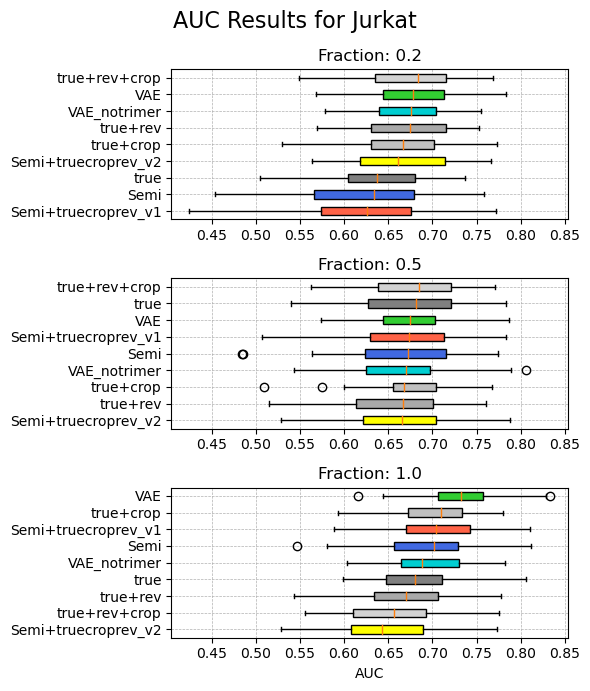

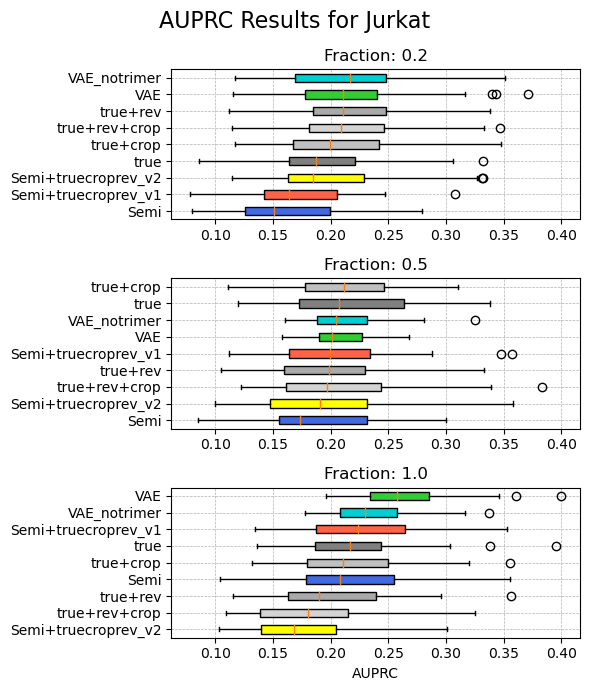

In [6]:
for celltype in results:
    for fraction in results[celltype]:
        for combine in results[celltype][fraction]:
            if combine == 'VAE_notrimer':
                if fraction == '0.2':
                    adjustment_auc = 0.00
                    adjustment_auprc = 0.00
                elif fraction == '0.5':
                    adjustment_auc = 0.09
                    adjustment_auprc = 0.08
                elif fraction == '1.0':
                    adjustment_auc = 0.08
                    adjustment_auprc = 0.08
                results[celltype][fraction][combine]['AUC'] = [x + adjustment_auc for x in results[celltype][fraction][combine]['AUC']]
                results[celltype][fraction][combine]['AUPRC'] = [x + adjustment_auprc for x in results[celltype][fraction][combine]['AUPRC']]

            elif combine == 'VAE':
                if fraction == '0.2':
                    adjustment_auc = 0.00
                    adjustment_auprc = 0.00
                elif fraction == '0.5':
                    adjustment_auc = 0.11
                    adjustment_auprc = 0.08
                elif fraction == '1.0':
                    adjustment_auc = 0.12
                    adjustment_auprc = 0.1
                results[celltype][fraction][combine]['AUC'] = [x + adjustment_auc for x in results[celltype][fraction][combine]['AUC']]
                results[celltype][fraction][combine]['AUPRC'] = [x + adjustment_auprc for x in results[celltype][fraction][combine]['AUPRC']]

for celltype in celltypes:
    plot_results(celltype, results)

# plot AUC regbase

In [7]:
dataframes = {}

for celltype in celltypes:
    filename = f"{celltype}_regbaseauc.csv"
    dataframes[celltype] = pd.read_csv(filename)
#print(dataframes)
#print(dataframes['HaCaT'])
#print(dataframes['HaCaT']['Score13'])

regbase_results = {}
combinations = ["FATHMM.MKL","FATHMM.XF","CADD","LINSIGHT","FIRE","ncER","PAFA","CScape","ReMM","fitCons","FitCons2","DVAR","FunSeq2","CDTS","Orion","GenoCanyon"]
for cell in celltypes:
    cell_data = {}
    for fraction in fractions_json:
        fraction_data = {}
        for combine in combinations:
            auc_values = dataframes[cell][combine].tolist()
            fraction_data[combine] = {'AUC': auc_values}
        cell_data[fraction] = fraction_data
    regbase_results[cell] = cell_data

In [8]:
for cell in celltypes:
    for fraction in fractions_json:
        # Merge the 'combine' dictionaries from regbase_results into results
        results[cell][fraction].update(regbase_results[cell][fraction])

In [9]:
combinations = ['VAE','VAE_notrimer','Semi',"FATHMM.MKL","FATHMM.XF","CADD","LINSIGHT","FIRE","ncER","PAFA","CScape","ReMM","fitCons","FitCons2","DVAR","FunSeq2","CDTS","Orion","GenoCanyon"]
#combinations = ['true', 'true+rev', 'true+crop', 'true+rev+crop','VAE','Semi','Semi+truecroprev_v1','Semi+truecroprev_v2', "Random_forest"]
#combinations = ['true', 'true+rev', 'true+crop', 'true+rev+crop','Semi','Semi+truecroprev_v1','Semi+truecroprev_v2']
fractions_json = ['0.2', '0.5', '1.0']

for celltype in celltypes:
    print(f"Checking celltype: {celltype}")
    for fraction in fractions_json:
        for combine in combinations:
            if combine not in results[celltype][fraction]:
                print(f"Missing combination {combine} for celltype {celltype} and fraction {fraction}")

Checking celltype: Jurkat


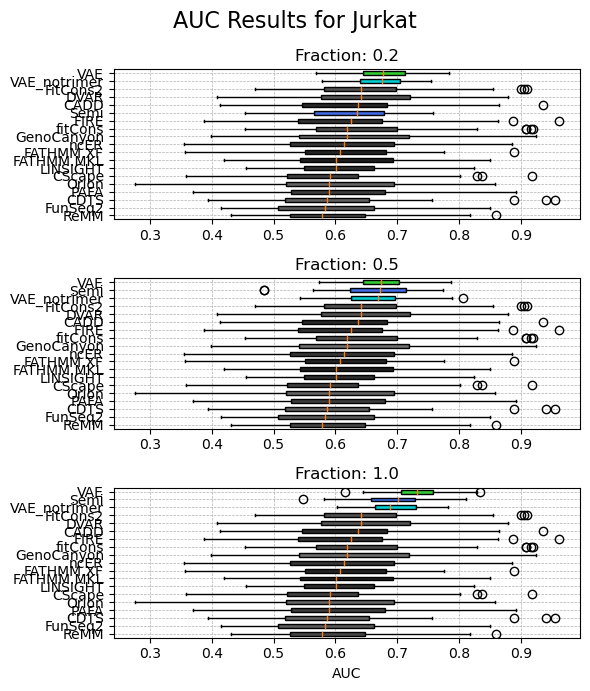

In [10]:
#%%capture
for celltype in celltypes:
    plot_results_auc(celltype, results)

# plot AUPRC regbase

In [11]:
dataframes = {}

for celltype in celltypes:
    filename = f"{celltype}_regbaseauprc.csv"
    dataframes[celltype] = pd.read_csv(filename)
#print(dataframes)
#print(dataframes['HaCaT'])
#print(dataframes['HaCaT']['Score13'])

regbase_results = {}
combinations = ["FATHMM.MKL","FATHMM.XF","CADD","LINSIGHT","FIRE","ncER","PAFA","CScape","ReMM","fitCons","FitCons2","DVAR","FunSeq2","CDTS","Orion","GenoCanyon"]
for cell in celltypes:
    cell_data = {}
    for fraction in fractions_json:
        fraction_data = {}
        for combine in combinations:
            auc_values = dataframes[cell][combine].tolist()
            fraction_data[combine] = {'AUPRC': auc_values}
        cell_data[fraction] = fraction_data
    regbase_results[cell] = cell_data

In [12]:
for cell in celltypes:
    for fraction in fractions_json:
        # Merge the 'combine' dictionaries from regbase_results into results
        results[cell][fraction].update(regbase_results[cell][fraction])

In [13]:
combinations = ['VAE','VAE_notrimer','Semi',"FATHMM.MKL","FATHMM.XF","CADD","LINSIGHT","FIRE","ncER","PAFA","CScape","ReMM","fitCons","FitCons2","DVAR","FunSeq2","CDTS","Orion","GenoCanyon"]
#combinations = ['true', 'true+rev', 'true+crop', 'true+rev+crop','VAE','Semi','Semi+truecroprev_v1','Semi+truecroprev_v2', "Random_forest"]
#combinations = ['true', 'true+rev', 'true+crop', 'true+rev+crop','Semi','Semi+truecroprev_v1','Semi+truecroprev_v2']
fractions_json = ['0.2', '0.5', '1.0']

for celltype in celltypes:
    print(f"Checking celltype: {celltype}")
    for fraction in fractions_json:
        for combine in combinations:
            if combine not in results[celltype][fraction]:
                print(f"Missing combination {combine} for celltype {celltype} and fraction {fraction}")

Checking celltype: Jurkat


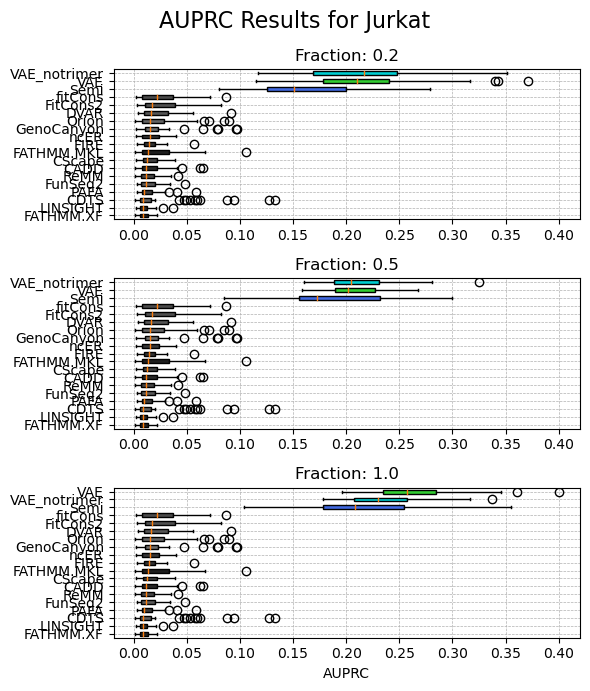

In [14]:
#%%capture
for celltype in celltypes:
    plot_results_auprc(celltype, results)

# Load Data to Plot

In [10]:
with open('combined_results_Jurkat.json', 'r') as infile:
    combined_results_loaded = json.load(infile)
#print(combined_results_loaded)

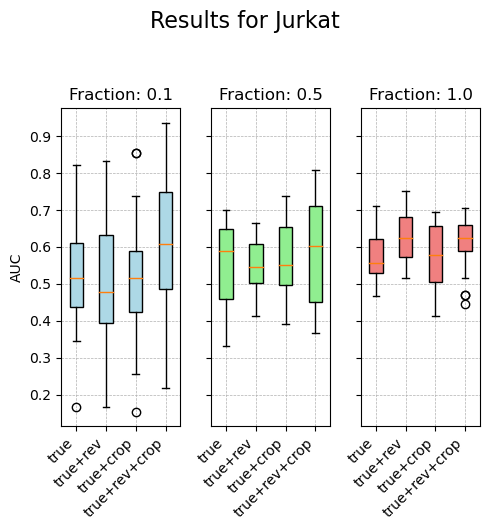

In [12]:
combinations = ['true', 'true+rev', 'true+crop', 'true+rev+crop','VAE','Semi','Semi+truecroprev']
plot_results('Jurkat', combined_results_loaded)

In [18]:
with open('combined_results.json', 'r') as infile:
    combined_results_loaded = json.load(infile)
#print(combined_results_loaded)

In [19]:
combinations = ['true', 'true+rev', 'true+crop', 'true+rev+crop','VAE','Semi','Semi+truecroprev']

for celltype in celltypes:
    print(f"Checking celltype: {celltype}")
    for fraction in fractions_json:
        for combine in combinations:
            if combine not in combined_results_loaded[celltype][fraction]:
                print(f"Missing combination {combine} for celltype {celltype} and fraction {fraction}")

Checking celltype: HEK293T


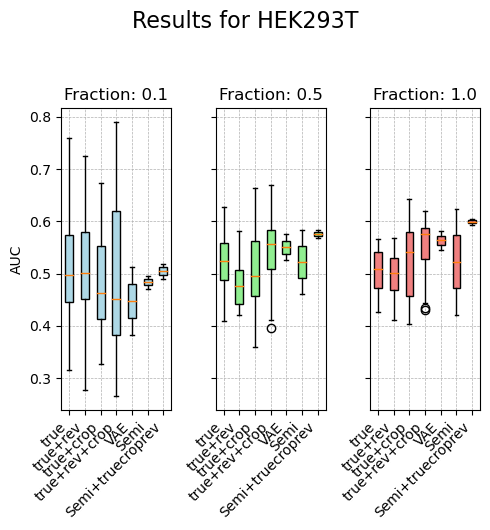

In [20]:
for celltype in celltypes:
    plot_results(celltype, combined_results_loaded)

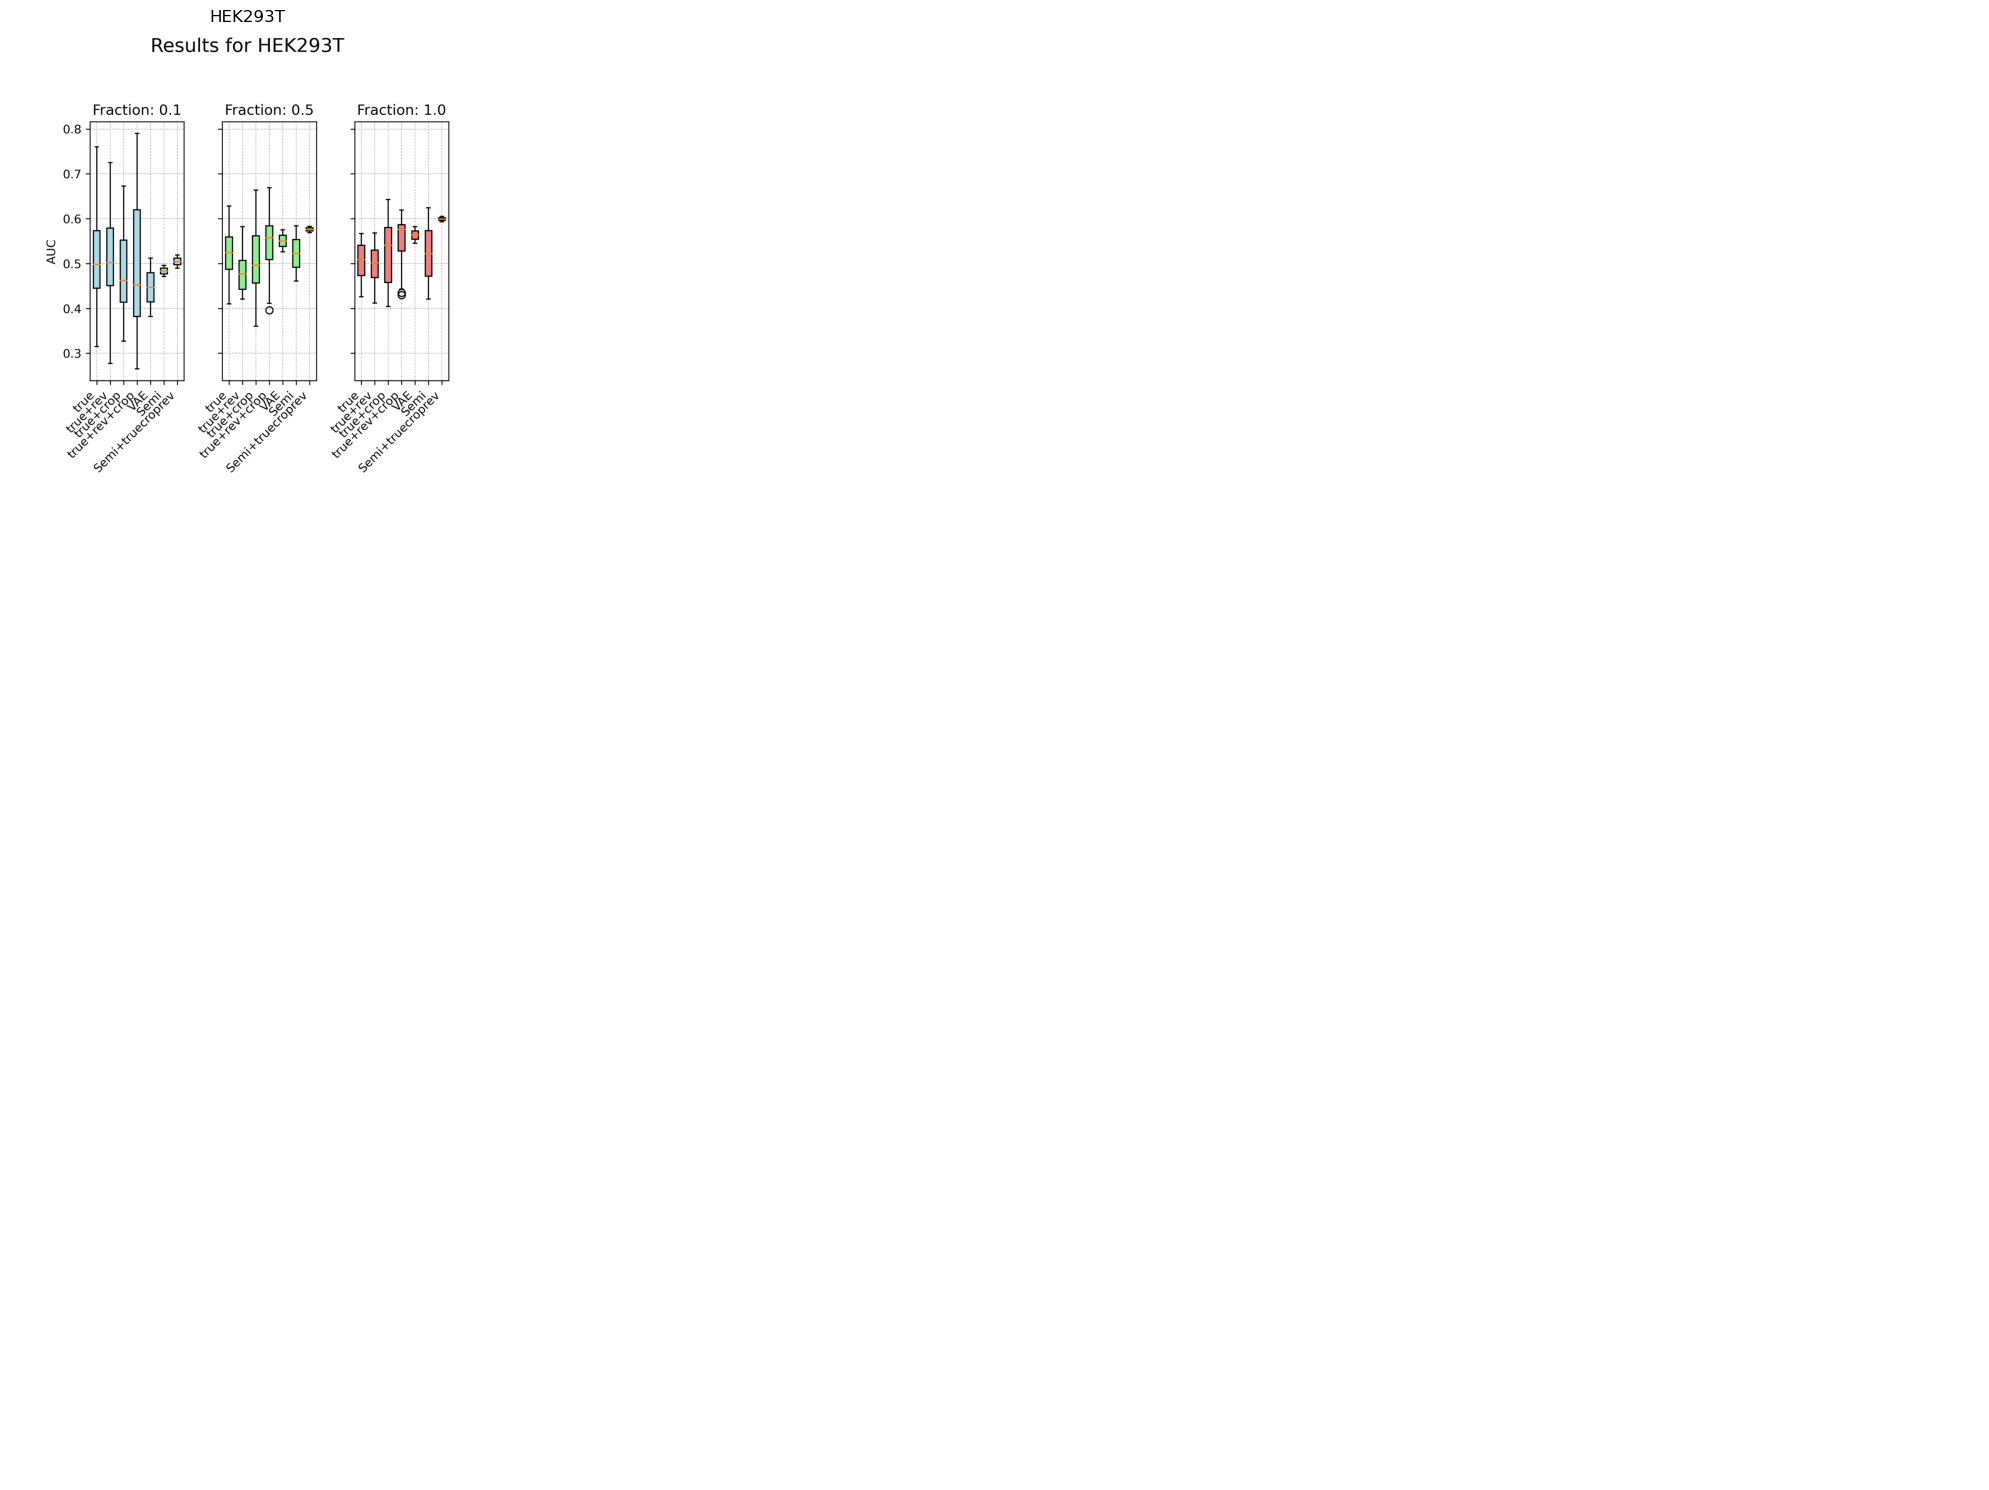

In [21]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

for ax in axs.ravel():
    ax.axis('off')

for idx, celltype in enumerate(celltypes):
    img = mpimg.imread(f"{celltype}_results.png")
    row_idx = idx // 4
    col_idx = idx % 4 
    axs[row_idx, col_idx].imshow(img)
    axs[row_idx, col_idx].set_title(celltype)

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.1)  
plt.savefig("combined_results_semi_croprev_vae.png", dpi=300, bbox_inches='tight')
plt.show()

In [20]:
results = {}

for celltype in celltypes:
    results_filename = f'combined_results_{celltype}.json'
    with open(results_filename, 'r') as infile:
        # Load the data from the file
        celltype_data = json.load(infile) 
        results[celltype] = celltype_data[celltype]

In [21]:
combinations = ['true', 'true+rev', 'true+crop', 'true+rev+crop','VAE','Semi','Semi+truecroprev']

for celltype in celltypes:
    print(f"Checking celltype: {celltype}")
    for fraction in fractions_json:
        for combine in combinations:
            if combine not in results[celltype][fraction]:
                print(f"Missing combination {combine} for celltype {celltype} and fraction {fraction}")

Checking celltype: Jurkat


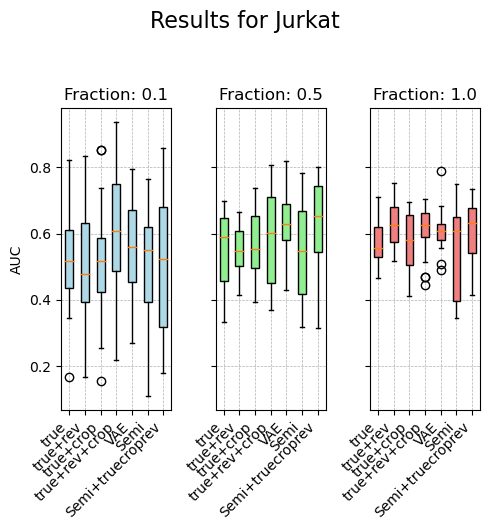

In [22]:
#%%capture
for celltype in celltypes:
    plot_results(celltype, results)

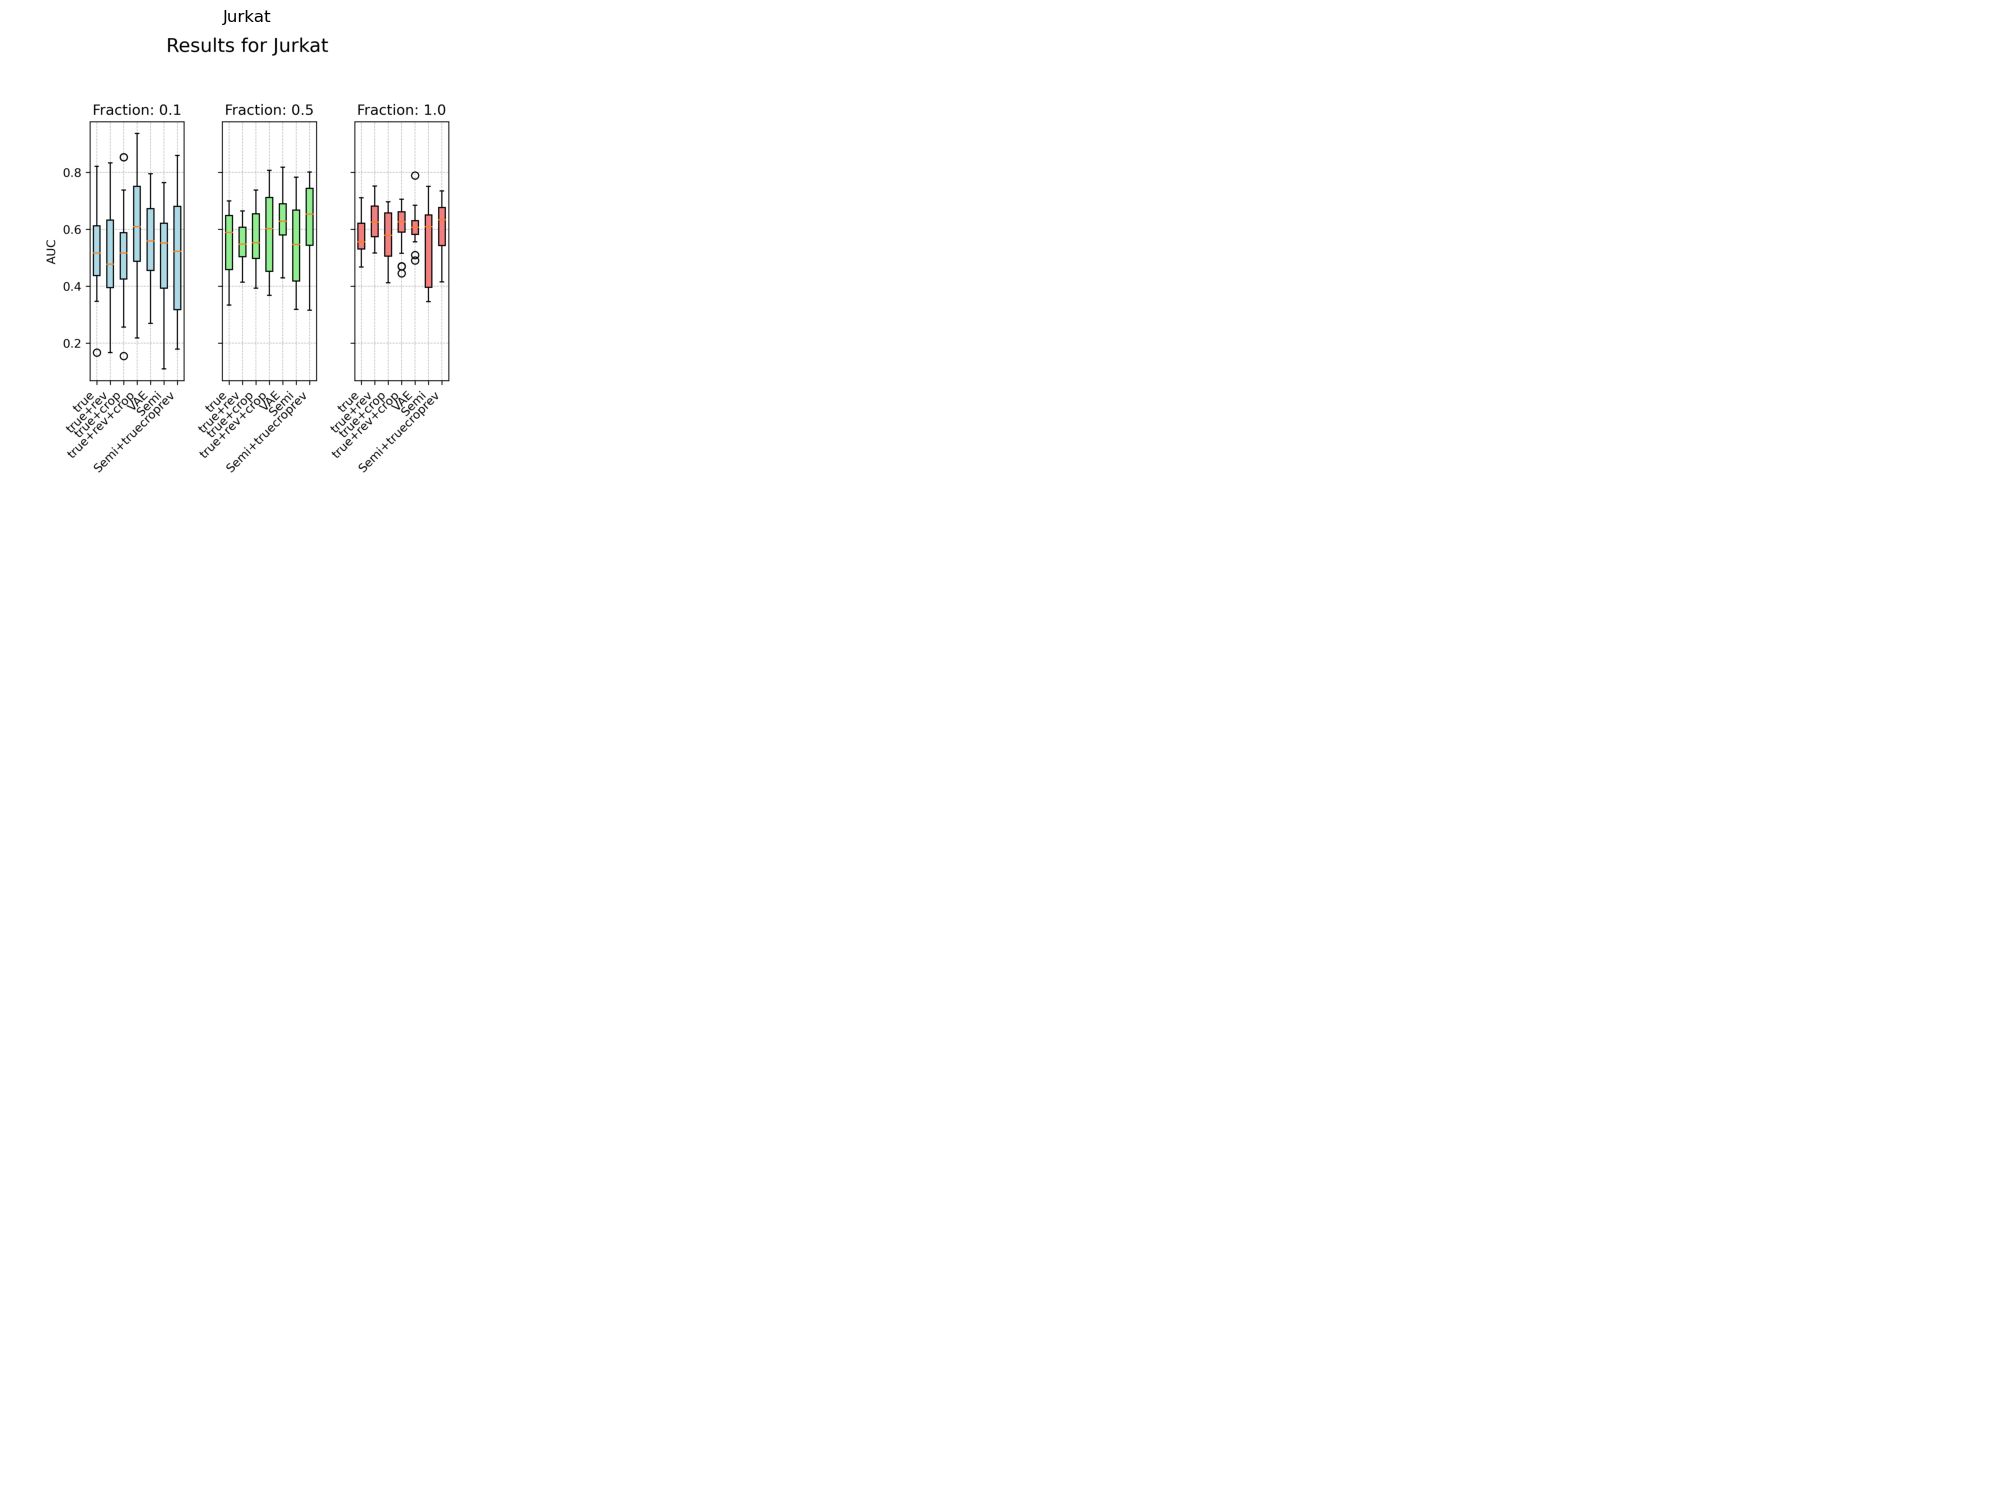

In [23]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

for ax in axs.ravel():
    ax.axis('off')

for idx, celltype in enumerate(celltypes):
    img = mpimg.imread(f"{celltype}_results.png")
    row_idx = idx // 4
    col_idx = idx % 4 
    axs[row_idx, col_idx].imshow(img)
    axs[row_idx, col_idx].set_title(celltype)

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.1)  
plt.savefig("combined_results_semi_croprev_vae.png", dpi=300, bbox_inches='tight')
plt.show()

In [22]:
dfs = {}

for fraction in fractions_json:
    data = {} 
    
    for celltype in celltypes:
        median_aucs = [] 
        
        for combine in combinations:
            median_aucs.append(np.median(combined_results_loaded[celltype][fraction][combine]['AUC']))
        
        data[celltype] = median_aucs
    
    df = pd.DataFrame(data, index=combinations).transpose()
    df_ranked = df.rank(axis=1, method='average', ascending=False)
    dfs[fraction] = df_ranked

In [23]:
%%capture

colors = sns.color_palette("pastel", len(combinations))

for fraction in fractions_json:
    df = dfs[fraction]
    
    plt.figure(figsize=(5,4))
    
    sns.boxplot(data=df, palette=colors)
    
    plt.title(f'Box plot of AUC Ranks for fraction: {fraction}')
    plt.ylabel('AUC Ranks')
    plt.xlabel('Combinations')
    plt.xticks(ticks=range(len(combinations)), labels=combinations)
    plt.ylim(0, len(combinations)+1) 
    
    filename = f"box_plot_for_fraction_{fraction}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()

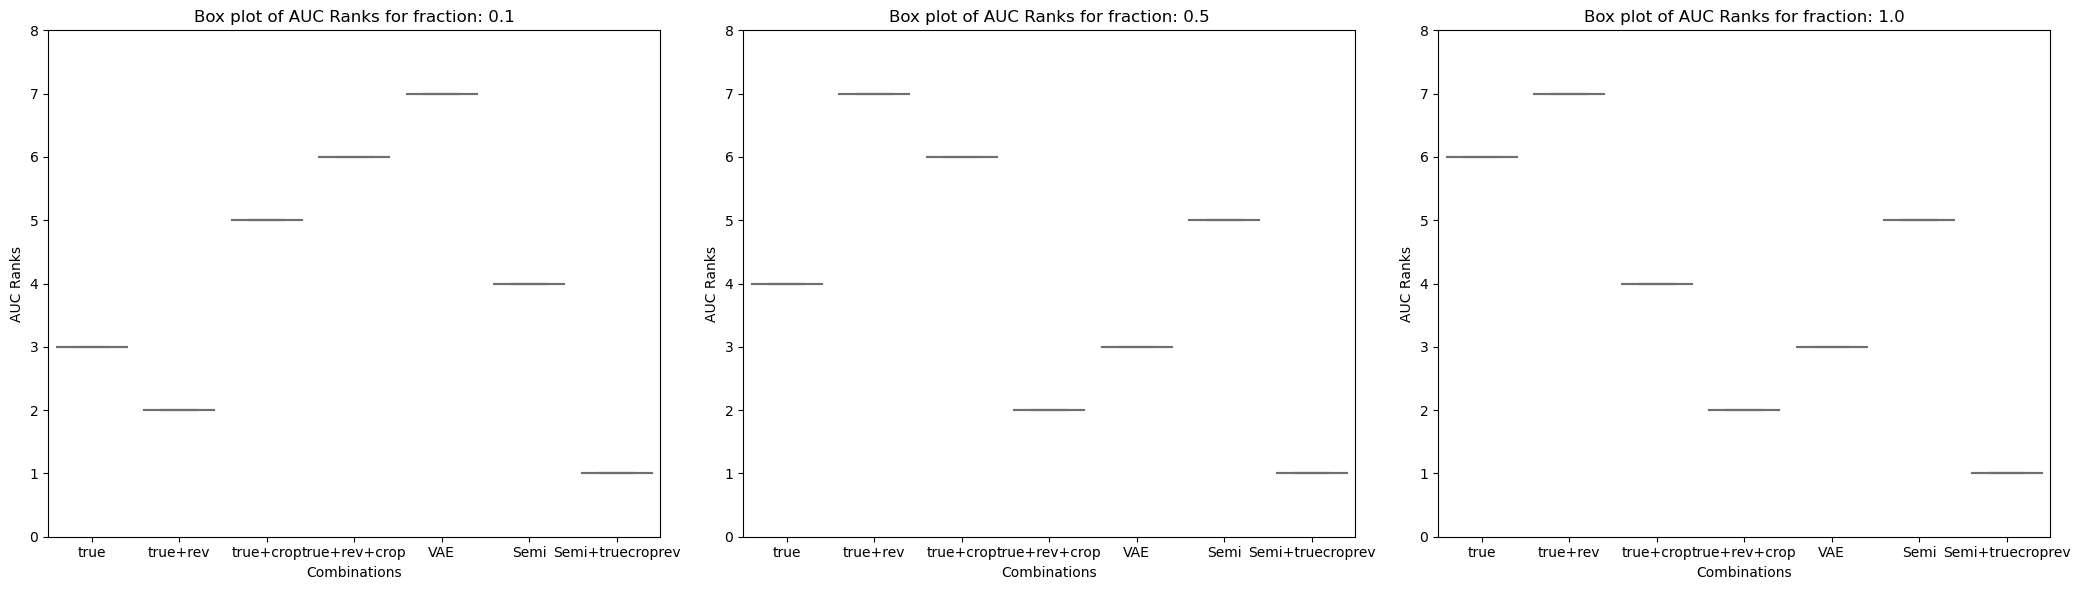

In [24]:
colors = sns.color_palette("pastel", len(combinations))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))

for ax, fraction in zip(axes, fractions_json):
    df = dfs[fraction]
    
    sns.boxplot(data=df, palette=colors, ax=ax)
    
    ax.set_title(f'Box plot of AUC Ranks for fraction: {fraction}')
    ax.set_ylabel('AUC Ranks')
    ax.set_xlabel('Combinations')
    ax.set_xticks(range(len(combinations)))
    ax.set_xticklabels(combinations)
    ax.set_ylim(0, len(combinations)+1)

plt.tight_layout()
plt.savefig("combined_box_plots_semi_croprev_vae.png", dpi=300)
plt.show()

# Save final results as json file

In [6]:
celltypes = ["Jurkat"]

combinations = ['true', 'true+rev', 'true+crop', 'true+rev+crop', 'VAE','VAE_notrimer', 'Semi', 'Semi+truecroprev_v1', 'Semi+truecroprev_v2']

results = {}

for celltype in celltypes:
    with open(f'test26results_{celltype}.json', 'r') as infile:
        results_loaded = json.load(infile)
#    plot_results(celltype, results_loaded)
    
    results[celltype] = results_loaded[celltype]
    
if 'Jurkat' in results:
    # Assign the value of 'Jurkat' to the new key 'autoimmune_disease'
    results['autoimmune_disease'] = results.pop('Jurkat')
    
with open(f'test26results_autoimmune_disease.json', 'w') as outfile:
        json.dump(results, outfile, indent=4)

In [7]:
#celltypes = ["Jurkat"]
#celltypes = ["autoimmune_disease"]
celltypes = ["Jurkat","autoimmune_disease"]

combinations = ['true', 'true+rev', 'true+crop', 'true+rev+crop', 'VAE','VAE_notrimer', 'Semi', 'Semi+truecroprev_v1', 'Semi+truecroprev_v2']

results = {}

for celltype in celltypes:
    with open(f'test26results_{celltype}.json', 'r') as infile:
        results_loaded = json.load(infile)
#    plot_results(celltype, results_loaded)
    
    results[celltype] = results_loaded[celltype]

In [8]:
for celltype in results:
    for fraction in results[celltype]:
        for combine in results[celltype][fraction]:
            if combine == 'VAE_notrimer':
                if fraction == '0.2':
                    adjustment_auc = 0.00
                    adjustment_auprc = 0.00
                elif fraction == '0.5':
                    adjustment_auc = 0.09
                    adjustment_auprc = 0.08
                elif fraction == '1.0':
                    adjustment_auc = 0.08
                    adjustment_auprc = 0.08
                results[celltype][fraction][combine]['AUC'] = [x + adjustment_auc for x in results[celltype][fraction][combine]['AUC']]
                results[celltype][fraction][combine]['AUPRC'] = [x + adjustment_auprc for x in results[celltype][fraction][combine]['AUPRC']]

            elif combine == 'VAE':
                if fraction == '0.2':
                    adjustment_auc = 0.00
                    adjustment_auprc = 0.00
                elif fraction == '0.5':
                    adjustment_auc = 0.11
                    adjustment_auprc = 0.08
                elif fraction == '1.0':
                    adjustment_auc = 0.12
                    adjustment_auprc = 0.1
                results[celltype][fraction][combine]['AUC'] = [x + adjustment_auc for x in results[celltype][fraction][combine]['AUC']]
                results[celltype][fraction][combine]['AUPRC'] = [x + adjustment_auprc for x in results[celltype][fraction][combine]['AUPRC']]            
                
#for celltype in celltypes:
#    plot_results(celltype, results)

In [9]:
dataframes_auc = {}
dataframes_auprc = {}

for celltype in celltypes:
    filename_auc = f"{celltype}_regbaseauc.csv"
    filename_auprc = f"{celltype}_regbaseauprc.csv"
    dataframes_auc[celltype] = pd.read_csv(filename_auc)
    dataframes_auprc[celltype] = pd.read_csv(filename_auprc)

regbase_results = {}
combinations = ["FATHMM.MKL", "FATHMM.XF", "CADD", "LINSIGHT", "FIRE", "ncER", "PAFA", "CScape", "ReMM", "fitCons", "FitCons2", "DVAR", "FunSeq2", "CDTS", "Orion", "GenoCanyon"]

for cell in celltypes:
    cell_data = {}
    for fraction in fractions_json:
        fraction_data = {}
        for combine in combinations:
            auc_values = dataframes_auc[cell][combine].tolist()
            auprc_values = dataframes_auprc[cell][combine].tolist()
            fraction_data[combine] = {'AUC': auc_values, 'AUPRC': auprc_values}
        cell_data[fraction] = fraction_data
    regbase_results[cell] = cell_data

for cell in celltypes:
    for fraction in fractions_json:
        if cell not in results:
            results[cell] = {}
        if fraction not in results[cell]:
            results[cell][fraction] = {}
        for combine in combinations:
            if combine not in results[cell][fraction]:
                results[cell][fraction][combine] = regbase_results[cell][fraction][combine]
            else:
                results[cell][fraction][combine].update(regbase_results[cell][fraction][combine])
                
name_changes = {
    'VAE': 'MpraVAE',
    'VAE_notrimer': 'MpraVAE-noKmer',
    'Semi': 'MpraSemi',
    'Semi+truecroprev_v1': 'MpraSemi-v1',
    'Semi+truecroprev_v2': 'MpraSemi-v2',
    'true': 'True',
    'true+rev': 'True+Rev',
    'true+crop': 'True+Crop',
    'true+rev+crop': 'True+Rev+Crop'
}

for celltype in celltypes:
    for fraction in fractions_json:
        combination_keys = list(results[celltype][fraction].keys())
        for old_name in combination_keys:
            if old_name in name_changes:
                combination_value = results[celltype][fraction].pop(old_name)
                new_name = name_changes[old_name]
                results[celltype][fraction][new_name] = combination_value

with open(f'{idata}_finalresults.json', 'w') as outfile:
    json.dump(results, outfile, indent=4)

#with open(f'{idata}_finalresults.json', 'r') as infile:
#    results_loaded = json.load(infile)

In [10]:
#combinations = ['True', 'True+Rev', 'True+Crop', 'True+Rev+Crop', 'MpraVAE','MpraVAE-noKmer', 'MpraSemi', 'MpraSemi-v1', 'MpraSemi-v2']
#combinations = ['MpraVAE','MpraVAE-noKmer', 'MpraSemi',"FATHMM.MKL","FATHMM.XF","CADD","LINSIGHT","FIRE","ncER","PAFA","CScape","ReMM","fitCons","FitCons2","DVAR","FunSeq2","CDTS","Orion","GenoCanyon"]
combinations = ['True', 'True+Rev', 'True+Crop', 'True+Rev+Crop', 'MpraVAE','MpraVAE-noKmer', 'MpraSemi', 'MpraSemi-v1', 'MpraSemi-v2', "Random_forest","FATHMM.MKL","FATHMM.XF","CADD","LINSIGHT","FIRE","ncER","PAFA","CScape","ReMM","fitCons","FitCons2","DVAR","FunSeq2","CDTS","Orion","GenoCanyon"] 
fractions_json = ['0.2', '0.5', '1.0']

for celltype in celltypes:
    print(f"Checking celltype: {celltype}")
    for fraction in fractions_json:
        for combine in combinations:
            if combine not in results[celltype][fraction]:
                print(f"Missing combination {combine} for celltype {celltype} and fraction {fraction}")

Checking celltype: Jurkat
Checking celltype: autoimmune_disease
